# PNP

In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [77]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

### Função gerar classificaton report mais completo

In [78]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

### Função para imprimir a quantidade de dados por conjunto

In [79]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

### Função para treinar e reportar

In [80]:
def treinar_e_reportar(models, X_train, y_train, X_test, y_test):
    for model in models:
        print(type(model).__name__)
        
        if(type(model).__name__ == 'XGBClassifier'):
            y_train = enc.transform(y_train.array.reshape(-1, 1))
            y_test = enc.transform(y_test.array.reshape(-1, 1))
            
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        if(type(model).__name__ == 'XGBClassifier'):
            preds = enc.inverse_transform(preds.reshape(-1,1))
            y_test = enc.inverse_transform(y_test.reshape(-1, 1))
            y_train = enc.inverse_transform(y_train.reshape(-1, 1))
        
        print('\n', 70*"-"," Teste ",  70*"-", '\n',)
        print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
        print(classification_report_extendido(y_test, preds))
        
            
        imprimeMatrizDeConfusão(y_test, preds, model)
        preds = model.predict(X_train)
        
        if(type(model).__name__ == 'XGBClassifier'):
            preds = enc.inverse_transform(preds.reshape(-1,1))
            
        print('\n', 70*"-"," Treino ",  70*"-", '\n',)
        print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
        print(classification_report_extendido(y_train, preds))
        print('\n', 150*"_", '\n',)

### Função para rodar GLM

In [81]:
def glm_treinar_e_reportar(df_train, df_test, method = 'bfgs'):
    from patsy import dmatrices
    import statsmodels.api as sm

    df_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]
    df_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]

    y_train, X_train = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_train, return_type='dataframe')

    y_test, X_test = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_test, return_type='dataframe')

    X_train, X_test = reescalar_dados(X_train, X_test)

    glm_model = sm.MNLogit(y_train, X_train) 

    glm_results = glm_model.fit(method=method)

    preds = glm_results.predict(X_test)

    preds[2] = preds.median(axis=1)

    preds = preds.reset_index(drop=True)

    b = np.zeros((preds.shape[0], 2))

    for i in range(preds.shape[0]):
        for j in range(2):
            if preds.loc[i,j] > preds.loc[i,2]:
                b[i,j] = 1
            else:
                b[i,j] = 0

    preds = pd.DataFrame(b, columns=['Não Pastejando', 'Pastejando'])

    print('Acurácia teste: ', accuracy_score(y_test, preds)*100)

    # Reverso de get_dummies
    preds = preds.idxmax(axis=1)

    y_test = y_test.rename(columns={"Comportamento[Não Pastejando]" : "Não Pastejando", "Comportamento[Pastejando]" : "Pastejando"})

    y_test = y_test.idxmax(axis=1)
    
    y_test = y_test.reset_index(drop=True)
    
    print(classification_report_extendido(y_test, preds))

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    plt.show()

## Leave One Group Out

In [82]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [83]:
# Modelos PNP
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, 
                           colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=50,
                                  criterion='entropy', min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.008851671496973969, max_depth=16,
                          min_child_weight=1, gamma=0.0, colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1)

rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", random_state=0)

models = [lgb_model, rf_model, knn_model, rn_model, xgb_model]

In [84]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [85]:
df = pd.read_csv(caminho_dados_lazaro)

In [86]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [87]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [88]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
df = df.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [89]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

enc = OrdinalEncoder()
enc.fit(y.array.reshape(-1, 1))

OrdinalEncoder()

In [90]:
# Para reescalar os dados
def reescalar_dados(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
    X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

    X_train = X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)
    X_test = X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

    columns = X_train.columns
    index_train = X_train.index
    index_test = X_test.index


    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)

    X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
    X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

    X_train = pd.concat([X_train, X_train_season], axis=1)
    X_test = pd.concat([X_test, X_test_season], axis=1)
    
    return X_train, X_test

#### Leave Fall Out

In [91]:
df_test = df[df.Season_fall == 1]

In [92]:
df_train = df[df.Season_fall == 0]

In [93]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

##### Quantidade de dados por conjunto

In [94]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  360787
Teste:  246363
-------------------------------------------


##### Treino e teste

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  67.16795947443407
{'Não Pastejando': {'precision': 0.6369528570598152, 'recall': 0.439468987506768, 'f1-score': 0.5200954042219929, 'support': 99734, 'specificity': 0.8296244262731111, 'npv': 0.685138354613604}, 'Pastejando': {'precision': 0.685138354613604, 'recall': 0.8296244262731111, 'f1-score': 0.750490468258375, 'support': 146629, 'specificity': 0.439468987506768, 'npv': 0.6369528570598152}, 'accuracy': 0.6716795947443407, 'macro avg': {'precision': 0.6610456058367096, 'recall': 0.6345467068899395, 'f1-score': 0.6352929362401839, 'support': 246363}, 'weighted avg': {'precision': 0.6656316412961433, 'recall': 0.6716795947443407, 'f1-score': 0.6572206943207116, 'support': 246363}}


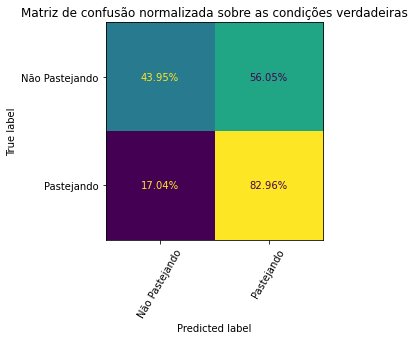


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  80.56748164429428
{'Não Pastejando': {'precision': 0.8240543749845385, 'recall': 0.7618064766957874, 'f1-score': 0.7917087547089092, 'support': 174904, 'specificity': 0.8469521150401059, 'npv': 0.7907481353122882}, 'Pastejando': {'precision': 0.7907481353122882, 'recall': 0.8469521150401059, 'f1-score': 0.8178856973645248, 'support': 185883, 'specificity': 0.7618064766957874, 'npv': 0.8240543749845385}, 'accuracy': 0.8056748164429428, 'macro avg': {'precision': 0.8074012551484133, 'recall': 0.8043792958679467, 'f1-score': 0.804797226036717, 'support': 360787}, 'weighted avg': {'precision': 0.8068944890989691, 'recall': 0.8056748164429428, 'f1-score': 0.805195517346293, 'support': 360787}}

 _______________________________________________________________________________________________________________________________

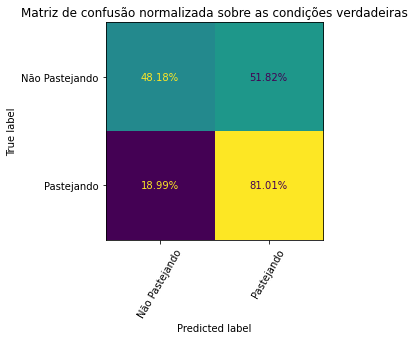


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  87.27836645998886
{'Não Pastejando': {'precision': 0.8920201774644463, 'recall': 0.8391631980972419, 'f1-score': 0.8647847656756343, 'support': 174904, 'specificity': 0.9044183706955451, 'npv': 0.8566551335816599}, 'Pastejando': {'precision': 0.8566551335816599, 'recall': 0.9044183706955451, 'f1-score': 0.8798890429958391, 'support': 185883, 'specificity': 0.8391631980972419, 'npv': 0.8920201774644463}, 'accuracy': 0.8727836645998885, 'macro avg': {'precision': 0.8743376555230531, 'recall': 0.8717907843963935, 'f1-score': 0.8723369043357367, 'support': 360787}, 'weighted avg': {'precision': 0.8737995640497057, 'recall': 0.8727836645998885, 'f1-score': 0.8725667211815468, 'support': 360787}}

 _____________________________________________________________________________________________________________________________

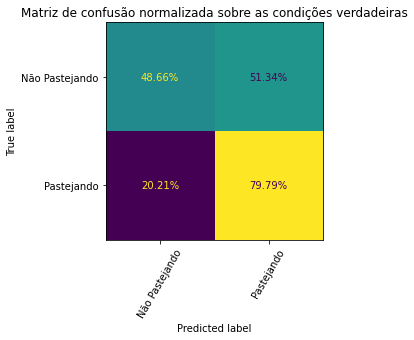


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.99113050082181
{'Não Pastejando': {'precision': 0.9998342194020465, 'recall': 0.9999828477336139, 'f1-score': 0.9999085280447298, 'support': 174904, 'specificity': 0.9998439878848523, 'npv': 0.9999838585579236}, 'Pastejando': {'precision': 0.9999838585579236, 'recall': 0.9998439878848523, 'f1-score': 0.9999139183300156, 'support': 185883, 'specificity': 0.9999828477336139, 'npv': 0.9998342194020465}, 'accuracy': 0.9999113050082181, 'macro avg': {'precision': 0.9999090389799851, 'recall': 0.999913417809233, 'f1-score': 0.9999112231873728, 'support': 360787}, 'weighted avg': {'precision': 0.9999113157919162, 'recall': 0.9999113050082181, 'f1-score': 0.9999113052024429, 'support': 360787}}

 ______________________________________________________________________________________________________________________________

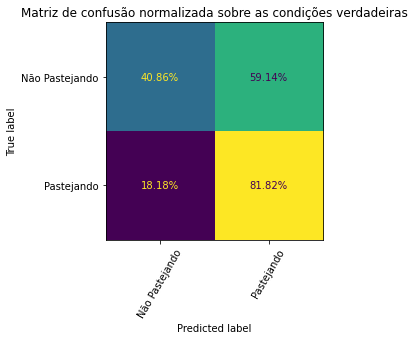


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  77.08980645089763
{'Não Pastejando': {'precision': 0.7864119871583902, 'recall': 0.7240714906462974, 'f1-score': 0.7539552840809304, 'support': 174904, 'specificity': 0.8149588719786102, 'npv': 0.7583905721208724}, 'Pastejando': {'precision': 0.7583905721208724, 'recall': 0.8149588719786102, 'f1-score': 0.7856577920343542, 'support': 185883, 'specificity': 0.7240714906462974, 'npv': 0.7864119871583902}, 'accuracy': 0.7708980645089762, 'macro avg': {'precision': 0.7724012796396313, 'recall': 0.7695151813124538, 'f1-score': 0.7698065380576422, 'support': 360787}, 'weighted avg': {'precision': 0.7719749240396555, 'recall': 0.7708980645089762, 'f1-score': 0.7702889027698141, 'support': 360787}}

 _____________________________________________________________________________________________________________________________

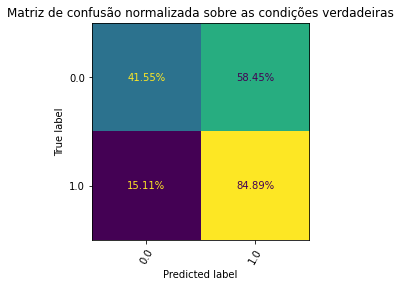


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  86.33542782860802
{'Não Pastejando': {'precision': 0.8852316223378153, 'recall': 0.8251040570827425, 'f1-score': 0.8541109348737008, 'support': 174904, 'specificity': 0.8993452870891905, 'npv': 0.8453199031163564}, 'Pastejando': {'precision': 0.8453199031163564, 'recall': 0.8993452870891905, 'f1-score': 0.8714961188178686, 'support': 185883, 'specificity': 0.8251040570827425, 'npv': 0.8852316223378153}, 'accuracy': 0.8633542782860801, 'macro avg': {'precision': 0.8652757627270858, 'recall': 0.8622246720859665, 'f1-score': 0.8628035268457848, 'support': 360787}, 'weighted avg': {'precision': 0.8646684920031789, 'recall': 0.8633542782860801, 'f1-score': 0.8630680484811581, 'support': 360787}}

 _____________________________________________________________________________________________________________________________

In [ ]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test)   

##### Com GLM 

In [195]:
df_test = df[df.Season_fall == 1]

In [196]:
df_train = df[df.Season_fall == 0]

         Current function value: 0.653760
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  62.25853719917358
{'Não Pastejando': {'precision': 0.5783101792796345, 'recall': 0.25001504000641706, 'f1-score': 0.3491050115154951, 'support': 99734, 'specificity': 0.8759999727202668, 'npv': 0.6319779971069541}, 'Pastejando': {'precision': 0.6319779971069541, 'recall': 0.8759999727202668, 'f1-score': 0.7342450875312612, 'support': 146629, 'specificity': 0.25001504000641706, 'npv': 0.5783101792796345}, 'accuracy': 0.6225853719917358, 'macro avg': {'precision': 0.6051440881932943, 'recall': 0.563007506363342, 'f1-score': 0.5416750495233782, 'support': 246363}, 'weighted avg': {'precision': 0.6102519012922827, 'recall': 0.6225853719917358, 'f1-score': 0.578330602233727, 'support': 246363}}


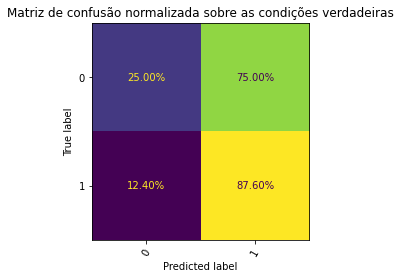

In [197]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 10 cm

In [95]:
df_test = df[df['Altura esperada'] == 10.0]

In [96]:
df_train = df[df['Altura esperada'] != 10.0]

In [97]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

##### Quantidade de dados por conjunto

In [98]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  458991
Teste:  148159
-------------------------------------------


##### Treino e teste

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  60.07532448248166
{'Não Pastejando': {'precision': 0.5820672478206724, 'recall': 0.32317194966427487, 'f1-score': 0.415598016163133, 'support': 65083, 'specificity': 0.8182146468294093, 'npv': 0.6067806898521745}, 'Pastejando': {'precision': 0.6067806898521745, 'recall': 0.8182146468294093, 'f1-score': 0.6968118913377755, 'support': 83076, 'specificity': 0.32317194966427487, 'npv': 0.5820672478206724}, 'accuracy': 0.6007532448248166, 'macro avg': {'precision': 0.5944239688364235, 'recall': 0.570693298246842, 'f1-score': 0.5562049537504543, 'support': 148159}, 'weighted avg': {'precision': 0.595924616662316, 'recall': 0.6007532448248166, 'f1-score': 0.5732808021836151, 'support': 148159}}


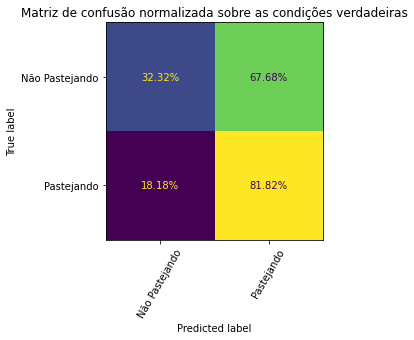


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  83.53845718107763
{'Não Pastejando': {'precision': 0.840303738317757, 'recall': 0.7894777027510678, 'f1-score': 0.8140981952833787, 'support': 209555, 'specificity': 0.8739516348883081, 'npv': 0.831689627676824}, 'Pastejando': {'precision': 0.831689627676824, 'recall': 0.8739516348883081, 'f1-score': 0.8522970518837957, 'support': 249436, 'specificity': 0.7894777027510678, 'npv': 0.840303738317757}, 'accuracy': 0.8353845718107763, 'macro avg': {'precision': 0.8359966829972905, 'recall': 0.8317146688196879, 'f1-score': 0.8331976235835872, 'support': 458991}, 'weighted avg': {'precision': 0.835622449791769, 'recall': 0.8353845718107763, 'f1-score': 0.8348571426156391, 'support': 458991}}

 __________________________________________________________________________________________________________________________________

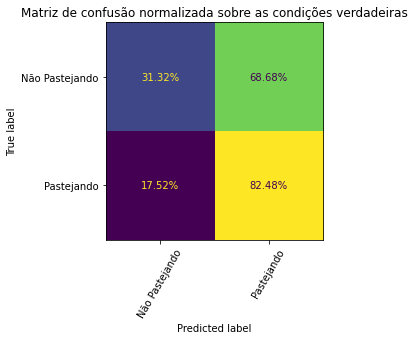


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  88.44291064530677
{'Não Pastejando': {'precision': 0.8971442781524844, 'recall': 0.8435780582663263, 'f1-score': 0.8695369873929532, 'support': 209555, 'specificity': 0.9187486970605686, 'npv': 0.8748644769190832}, 'Pastejando': {'precision': 0.8748644769190832, 'recall': 0.9187486970605686, 'f1-score': 0.8962697307698325, 'support': 249436, 'specificity': 0.8435780582663263, 'npv': 0.8971442781524844}, 'accuracy': 0.8844291064530677, 'macro avg': {'precision': 0.8860043775357838, 'recall': 0.8811633776634474, 'f1-score': 0.8829033590813928, 'support': 458991}, 'weighted avg': {'precision': 0.885036449239816, 'recall': 0.8844291064530677, 'f1-score': 0.8840647419174543, 'support': 458991}}

 ______________________________________________________________________________________________________________________________

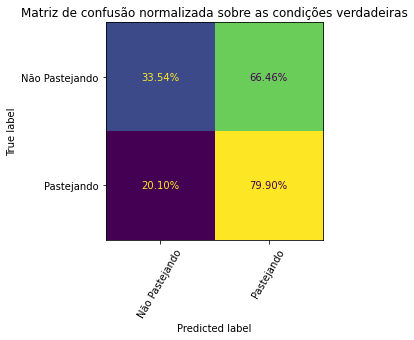


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.99259244734647
{'Não Pastejando': {'precision': 0.9998520872399002, 'recall': 0.9999856839493212, 'f1-score': 0.9999188811322286, 'support': 209555, 'specificity': 0.9998757196234705, 'npv': 0.9999879715165512}, 'Pastejando': {'precision': 0.9999879715165512, 'recall': 0.9998757196234705, 'f1-score': 0.9999318424196743, 'support': 249436, 'specificity': 0.9999856839493212, 'npv': 0.9998520872399002}, 'accuracy': 0.9999259244734646, 'macro avg': {'precision': 0.9999200293782257, 'recall': 0.9999307017863959, 'f1-score': 0.9999253617759514, 'support': 458991}, 'weighted avg': {'precision': 0.999925932762864, 'recall': 0.9999259244734646, 'f1-score': 0.9999259248688058, 'support': 458991}}

 ______________________________________________________________________________________________________________________________

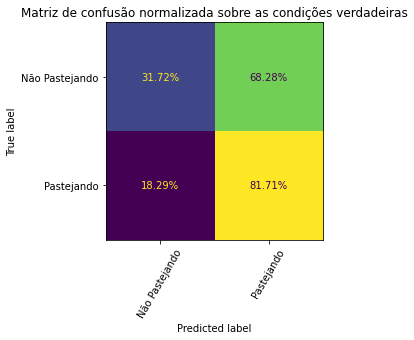


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  81.03971537568275
{'Não Pastejando': {'precision': 0.807353671568111, 'recall': 0.7679559065639092, 'f1-score': 0.7871621291124132, 'support': 209555, 'specificity': 0.8460526948796485, 'npv': 0.8127334765964985}, 'Pastejando': {'precision': 0.8127334765964985, 'recall': 0.8460526948796485, 'f1-score': 0.8290584524001272, 'support': 249436, 'specificity': 0.7679559065639092, 'npv': 0.807353671568111}, 'accuracy': 0.8103971537568275, 'macro avg': {'precision': 0.8100435740823048, 'recall': 0.8070043007217789, 'f1-score': 0.8081102907562703, 'support': 458991}, 'weighted avg': {'precision': 0.8102772954454003, 'recall': 0.8103971537568275, 'f1-score': 0.8099304432963389, 'support': 458991}}

 _______________________________________________________________________________________________________________________________

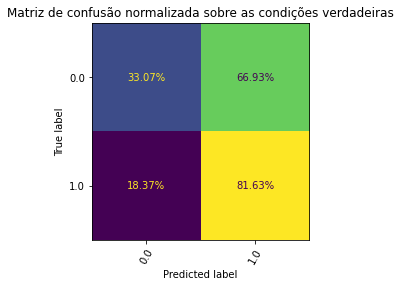


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  87.71914917721698
{'Não Pastejando': {'precision': 0.8854711350219677, 'recall': 0.8396077402114004, 'f1-score': 0.8619297695563568, 'support': 209555, 'specificity': 0.9087661764941708, 'npv': 0.8708709516308732}, 'Pastejando': {'precision': 0.8708709516308732, 'recall': 0.9087661764941708, 'f1-score': 0.8894150975229829, 'support': 249436, 'specificity': 0.8396077402114004, 'npv': 0.8854711350219677}, 'accuracy': 0.8771914917721698, 'macro avg': {'precision': 0.8781710433264205, 'recall': 0.8741869583527856, 'f1-score': 0.8756724335396698, 'support': 458991}, 'weighted avg': {'precision': 0.8775367499374213, 'recall': 0.8771914917721698, 'f1-score': 0.8768665118164084, 'support': 458991}}

 _____________________________________________________________________________________________________________________________

In [201]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [202]:
df_test = df[df['Altura esperada'] == 10.0]

In [203]:
df_train = df[df['Altura esperada'] != 10.0]

         Current function value: 0.633380
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  54.56435316113095
{'Não Pastejando': {'precision': 0.47231996828071565, 'recall': 0.29285681360724, 'f1-score': 0.3615429118810285, 'support': 65083, 'specificity': 0.743680485338726, 'npv': 0.5730903019340476}, 'Pastejando': {'precision': 0.5730903019340476, 'recall': 0.743680485338726, 'f1-score': 0.6473352507583259, 'support': 83076, 'specificity': 0.29285681360724, 'npv': 0.47231996828071565}, 'accuracy': 0.5456435316113095, 'macro avg': {'precision': 0.5227051351073817, 'recall': 0.518268649472983, 'f1-score': 0.5044390813196772, 'support': 148159}, 'weighted avg': {'precision': 0.5288241039632203, 'recall': 0.5456435316113095, 'f1-score': 0.5217929428921069, 'support': 148159}}


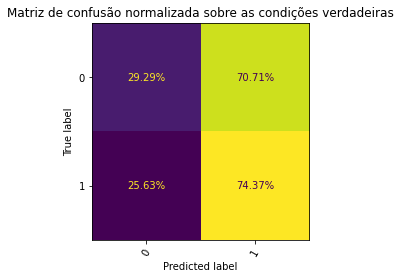

In [204]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 15 cm

In [99]:
df_test = df[df['Altura esperada'] == 15.0]

In [100]:
df_train = df[df['Altura esperada'] != 15.0]

In [101]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

##### Quantidade de dados por conjunto

In [103]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  548669
Teste:  58481
-------------------------------------------


##### Treino e teste

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  64.59020878575947
{'Não Pastejando': {'precision': 0.47271595154534135, 'recall': 0.42296393841166935, 'f1-score': 0.4464581662657044, 'support': 19744, 'specificity': 0.7595322301675401, 'npv': 0.720862428028911}, 'Pastejando': {'precision': 0.720862428028911, 'recall': 0.7595322301675401, 'f1-score': 0.7396922767497989, 'support': 38737, 'specificity': 0.42296393841166935, 'npv': 0.47271595154534135}, 'accuracy': 0.6459020878575947, 'macro avg': {'precision': 0.5967891897871261, 'recall': 0.5912480842896047, 'f1-score': 0.5930752215077516, 'support': 58481}, 'weighted avg': {'precision': 0.6370847219074083, 'recall': 0.6459020878575947, 'f1-score': 0.6406923575042669, 'support': 58481}}


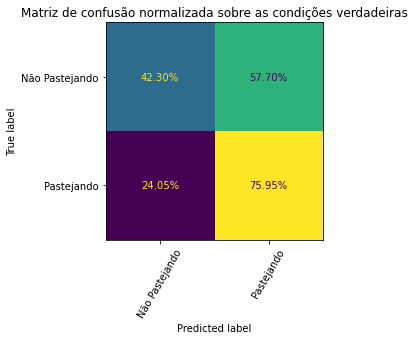


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  82.24503297981114
{'Não Pastejando': {'precision': 0.8306971860562788, 'recall': 0.77596569554403, 'f1-score': 0.8023992178403794, 'support': 254894, 'specificity': 0.8627827418943068, 'npv': 0.8161278170068487}, 'Pastejando': {'precision': 0.8161278170068487, 'recall': 0.8627827418943068, 'f1-score': 0.8388070370517453, 'support': 293775, 'specificity': 0.77596569554403, 'npv': 0.8306971860562788}, 'accuracy': 0.8224503297981114, 'macro avg': {'precision': 0.8234125015315638, 'recall': 0.8193742187191684, 'f1-score': 0.8206031274460623, 'support': 548669}, 'weighted avg': {'precision': 0.8228962780543755, 'recall': 0.8224503297981114, 'f1-score': 0.8218931332772257, 'support': 548669}}

 _________________________________________________________________________________________________________________________________

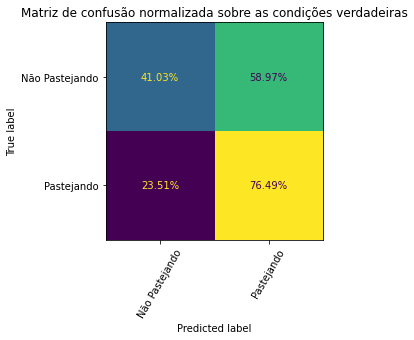


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  88.16864083810093
{'Não Pastejando': {'precision': 0.8960255485560146, 'recall': 0.843166178882202, 'f1-score': 0.8687925845526335, 'support': 254894, 'specificity': 0.9151085014041358, 'npv': 0.8705490719272567}, 'Pastejando': {'precision': 0.8705490719272567, 'recall': 0.9151085014041358, 'f1-score': 0.8922728170372078, 'support': 293775, 'specificity': 0.843166178882202, 'npv': 0.8960255485560146}, 'accuracy': 0.8816864083810093, 'macro avg': {'precision': 0.8832873102416356, 'recall': 0.8791373401431689, 'f1-score': 0.8805327007949206, 'support': 548669}, 'weighted avg': {'precision': 0.8823846249361028, 'recall': 0.8816864083810093, 'f1-score': 0.8813646549596655, 'support': 548669}}

 _______________________________________________________________________________________________________________________________

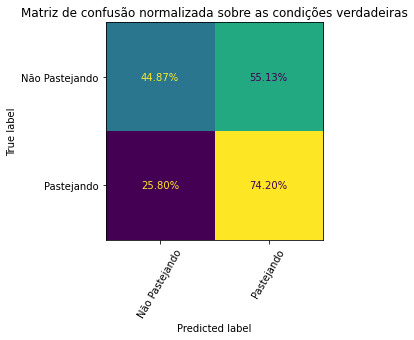


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.99362092627796
{'Não Pastejando': {'precision': 0.9998666284858018, 'recall': 0.9999960768005524, 'f1-score': 0.9999313484536729, 'support': 254894, 'specificity': 0.9998842651689218, 'npv': 0.9999965956519667}, 'Pastejando': {'precision': 0.9999965956519667, 'recall': 0.9998842651689218, 'f1-score': 0.9999404272557221, 'support': 293775, 'specificity': 0.9999960768005524, 'npv': 0.9998666284858018}, 'accuracy': 0.9999362092627796, 'macro avg': {'precision': 0.9999316120688843, 'recall': 0.9999401709847371, 'f1-score': 0.9999358878546976, 'support': 548669}, 'weighted avg': {'precision': 0.9999362170797266, 'recall': 0.9999362092627796, 'f1-score': 0.9999362095358043, 'support': 548669}}

 _____________________________________________________________________________________________________________________________

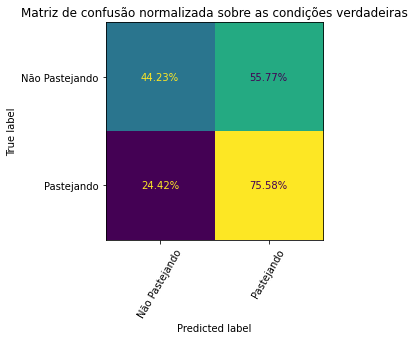


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  79.84322059383709
{'Não Pastejando': {'precision': 0.8066923979392311, 'recall': 0.7445290983703029, 'f1-score': 0.7743651891477233, 'support': 254894, 'specificity': 0.8452012594672794, 'npv': 0.7922320742014632}, 'Pastejando': {'precision': 0.7922320742014632, 'recall': 0.8452012594672794, 'f1-score': 0.8178599191030186, 'support': 293775, 'specificity': 0.7445290983703029, 'npv': 0.8066923979392311}, 'accuracy': 0.7984322059383708, 'macro avg': {'precision': 0.7994622360703472, 'recall': 0.7948651789187912, 'f1-score': 0.796112554125371, 'support': 548669}, 'weighted avg': {'precision': 0.7989498762985648, 'recall': 0.7984322059383708, 'f1-score': 0.7976536641529028, 'support': 548669}}

 ______________________________________________________________________________________________________________________________

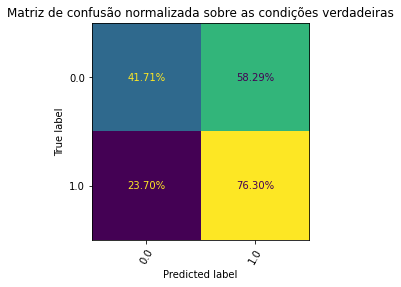


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  86.56785785236636
{'Não Pastejando': {'precision': 0.8754174850617008, 'recall': 0.8288190385022793, 'f1-score': 0.8514811978557898, 'support': 254894, 'specificity': 0.8976597736362862, 'npv': 0.8580315803515941}, 'Pastejando': {'precision': 0.8580315803515941, 'recall': 0.8976597736362862, 'f1-score': 0.8773984475593809, 'support': 293775, 'specificity': 0.8288190385022793, 'npv': 0.8754174850617008}, 'accuracy': 0.8656785785236636, 'macro avg': {'precision': 0.8667245327066475, 'recall': 0.8632394060692827, 'f1-score': 0.8644398227075853, 'support': 548669}, 'weighted avg': {'precision': 0.8661085134299673, 'recall': 0.8656785785236636, 'f1-score': 0.8653581255329001, 'support': 548669}}

 _____________________________________________________________________________________________________________________________

In [208]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [209]:
df_test = df[df['Altura esperada'] == 15.0]

In [210]:
df_train = df[df['Altura esperada'] != 15.0]

         Current function value: 0.654017
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  69.43451719361843
{'Não Pastejando': {'precision': 0.5513998129915846, 'recall': 0.5077491896272285, 'f1-score': 0.5286750164798946, 'support': 19744, 'specificity': 0.7894519451687018, 'npv': 0.758833746898263}, 'Pastejando': {'precision': 0.758833746898263, 'recall': 0.7894519451687018, 'f1-score': 0.7738401002062325, 'support': 38737, 'specificity': 0.5077491896272285, 'npv': 0.5513998129915846}, 'accuracy': 0.6943451719361844, 'macro avg': {'precision': 0.6551167799449238, 'recall': 0.6486005673979651, 'f1-score': 0.6512575583430635, 'support': 58481}, 'weighted avg': {'precision': 0.6888011621091271, 'recall': 0.6943451719361844, 'f1-score': 0.6910689537981202, 'support': 58481}}


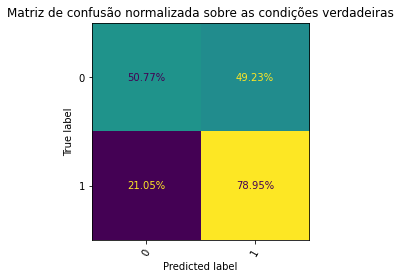

In [211]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 20 cm

In [104]:
df_test = df[df['Altura esperada'] == 20.0]

In [105]:
df_train = df[df['Altura esperada'] != 20.0]

In [106]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

##### Quantidade de dados por conjunto

In [107]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  500386
Teste:  106764
-------------------------------------------


##### Treino e teste

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  63.0568356374808
{'Não Pastejando': {'precision': 0.6757166813063963, 'recall': 0.4822110361857726, 'f1-score': 0.5627951315760303, 'support': 52645, 'specificity': 0.7748849757016945, 'npv': 0.6060553508201459}, 'Pastejando': {'precision': 0.6060553508201459, 'recall': 0.7748849757016945, 'f1-score': 0.6801498613296137, 'support': 54119, 'specificity': 0.4822110361857726, 'npv': 0.6757166813063963}, 'accuracy': 0.630568356374808, 'macro avg': {'precision': 0.6408860160632711, 'recall': 0.6285480059437335, 'f1-score': 0.621472496452822, 'support': 106764}, 'weighted avg': {'precision': 0.6404051386086201, 'recall': 0.630568356374808, 'f1-score': 0.6222826050646049, 'support': 106764}}


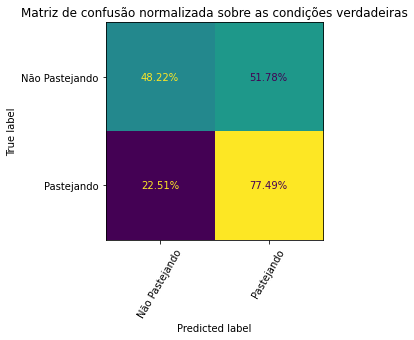


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  83.17958536010201
{'Não Pastejando': {'precision': 0.8376631649092549, 'recall': 0.7701008590360957, 'f1-score': 0.8024624425872077, 'support': 221993, 'specificity': 0.8809919789649884, 'npv': 0.8277544904116801}, 'Pastejando': {'precision': 0.8277544904116801, 'recall': 0.8809919789649884, 'f1-score': 0.8535439044634421, 'support': 278393, 'specificity': 0.7701008590360957, 'npv': 0.8376631649092549}, 'accuracy': 0.83179585360102, 'macro avg': {'precision': 0.8327088276604675, 'recall': 0.825546419000542, 'f1-score': 0.8280031735253248, 'support': 500386}, 'weighted avg': {'precision': 0.8321504095176105, 'recall': 0.83179585360102, 'f1-score': 0.8308819455631313, 'support': 500386}}

 __________________________________________________________________________________________________________________________________

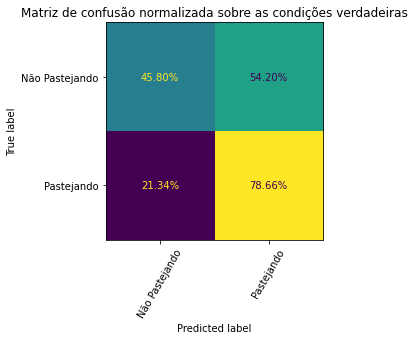


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  88.51766436311168
{'Não Pastejando': {'precision': 0.8991581960651125, 'recall': 0.8348056019784408, 'f1-score': 0.8657877401903303, 'support': 221993, 'specificity': 0.9253429504333801, 'npv': 0.8753844114978541}, 'Pastejando': {'precision': 0.8753844114978541, 'recall': 0.9253429504333801, 'f1-score': 0.8996706677795745, 'support': 278393, 'specificity': 0.8348056019784408, 'npv': 0.8991581960651125}, 'accuracy': 0.8851766436311168, 'macro avg': {'precision': 0.8872713037814832, 'recall': 0.8800742762059104, 'f1-score': 0.8827292039849524, 'support': 500386}, 'weighted avg': {'precision': 0.8859314966629854, 'recall': 0.8851766436311168, 'f1-score': 0.8846387269492573, 'support': 500386}}

 _____________________________________________________________________________________________________________________________

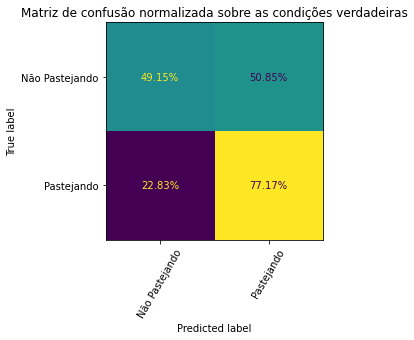


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.99400462842686
{'Não Pastejando': {'precision': 0.9998738846675285, 'recall': 0.9999909907069142, 'f1-score': 0.9999324342585335, 'support': 221993, 'specificity': 0.9998994227584745, 'npv': 0.9999928152403122}, 'Pastejando': {'precision': 0.9999928152403122, 'recall': 0.9998994227584745, 'f1-score': 0.9999461168187369, 'support': 278393, 'specificity': 0.9999909907069142, 'npv': 0.9998738846675285}, 'accuracy': 0.9999400462842686, 'macro avg': {'precision': 0.9999333499539204, 'recall': 0.9999452067326944, 'f1-score': 0.9999392755386352, 'support': 500386}, 'weighted avg': {'precision': 0.9999400524638877, 'recall': 0.9999400462842686, 'f1-score': 0.9999400466397407, 'support': 500386}}

 _____________________________________________________________________________________________________________________________

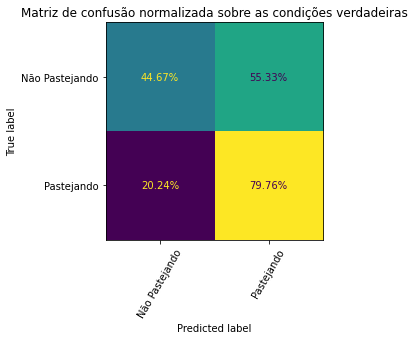


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  80.64534179613338
{'Não Pastejando': {'precision': 0.8131208246803613, 'recall': 0.7319600167572852, 'f1-score': 0.7704087922091468, 'support': 221993, 'specificity': 0.8658551041154052, 'npv': 0.8020202894017987}, 'Pastejando': {'precision': 0.8020202894017987, 'recall': 0.8658551041154052, 'f1-score': 0.832716117621048, 'support': 278393, 'specificity': 0.7319600167572852, 'npv': 0.8131208246803613}, 'accuracy': 0.8064534179613339, 'macro avg': {'precision': 0.80757055704108, 'recall': 0.7989075604363451, 'f1-score': 0.8015624549150975, 'support': 500386}, 'weighted avg': {'precision': 0.8069449698047156, 'recall': 0.8064534179613339, 'f1-score': 0.8050738772502859, 'support': 500386}}

 ________________________________________________________________________________________________________________________________

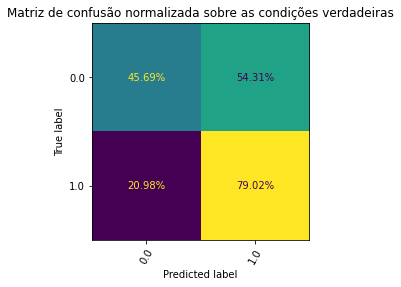


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  87.36335548956205
{'Não Pastejando': {'precision': 0.8825658449601195, 'recall': 0.8249269121098413, 'f1-score': 0.8527735349998137, 'support': 221993, 'specificity': 0.9124726555624603, 'npv': 0.8673055846714307}, 'Pastejando': {'precision': 0.8673055846714307, 'recall': 0.9124726555624603, 'f1-score': 0.8893159969472277, 'support': 278393, 'specificity': 0.8249269121098413, 'npv': 0.8825658449601195}, 'accuracy': 0.8736335548956206, 'macro avg': {'precision': 0.874935714815775, 'recall': 0.8686997838361508, 'f1-score': 0.8710447659735208, 'support': 500386}, 'weighted avg': {'precision': 0.8740757000668792, 'recall': 0.8736335548956206, 'f1-score': 0.8731041709667001, 'support': 500386}}

 ______________________________________________________________________________________________________________________________

In [215]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [216]:
df_test = df[df['Altura esperada'] == 20.0]

In [217]:
df_train = df[df['Altura esperada'] != 20.0]

         Current function value: 0.640972
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  61.51886403656663
{'Não Pastejando': {'precision': 0.7090823597497016, 'recall': 0.3723810428340773, 'f1-score': 0.488317640611767, 'support': 52645, 'specificity': 0.8513830632495057, 'npv': 0.582377997143471}, 'Pastejando': {'precision': 0.582377997143471, 'recall': 0.8513830632495057, 'f1-score': 0.6916449007775676, 'support': 54119, 'specificity': 0.3723810428340773, 'npv': 0.7090823597497016}, 'accuracy': 0.6151886403656663, 'macro avg': {'precision': 0.6457301784465863, 'recall': 0.6118820530417916, 'f1-score': 0.5899812706946673, 'support': 106764}, 'weighted avg': {'precision': 0.6448555286091805, 'recall': 0.6151886403656663, 'f1-score': 0.591384854212915, 'support': 106764}}


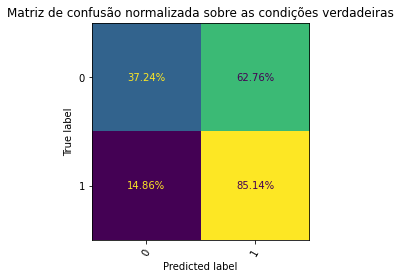

In [218]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 25 cm

In [108]:
df_test = df[df['Altura esperada'] == 25.0]

In [109]:
df_train = df[df['Altura esperada'] != 25.0]

In [110]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

##### Quantidade de dados por conjunto

In [111]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  327895
Teste:  279255
-------------------------------------------


##### Treino e teste

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  64.60725859877174
{'Não Pastejando': {'precision': 0.6626172780547016, 'recall': 0.5063600076031173, 'f1-score': 0.5740451830335209, 'support': 131525, 'specificity': 0.7704596222838963, 'npv': 0.6367694941425263}, 'Pastejando': {'precision': 0.6367694941425263, 'recall': 0.7704596222838963, 'f1-score': 0.6972641174236391, 'support': 147730, 'specificity': 0.5063600076031173, 'npv': 0.6626172780547016}, 'accuracy': 0.6460725859877173, 'macro avg': {'precision': 0.6496933860986139, 'recall': 0.6384098149435068, 'f1-score': 0.63565465022858, 'support': 279255}, 'weighted avg': {'precision': 0.6489434204072265, 'recall': 0.6460725859877173, 'f1-score': 0.6392298106228288, 'support': 279255}}


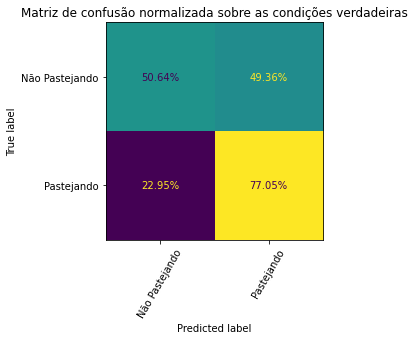


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  83.17083212613794
{'Não Pastejando': {'precision': 0.8509407003568036, 'recall': 0.7449008825194078, 'f1-score': 0.7943977465796298, 'support': 143113, 'specificity': 0.8989403729800521, 'npv': 0.8198167963043392}, 'Pastejando': {'precision': 0.8198167963043392, 'recall': 0.8989403729800521, 'f1-score': 0.857557344126712, 'support': 184782, 'specificity': 0.7449008825194078, 'npv': 0.8509407003568036}, 'accuracy': 0.8317083212613794, 'macro avg': {'precision': 0.8353787483305715, 'recall': 0.82192062774973, 'f1-score': 0.8259775453531709, 'support': 327895}, 'weighted avg': {'precision': 0.8334011305596963, 'recall': 0.8317083212613794, 'f1-score': 0.8299907161398395, 'support': 327895}}

 ________________________________________________________________________________________________________________________________

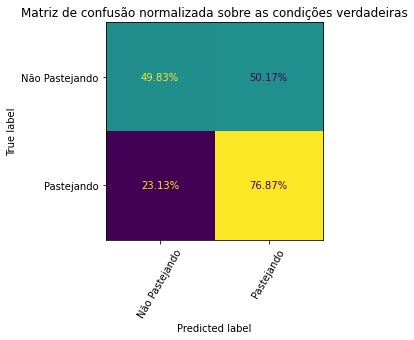


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  88.09832415864834
{'Não Pastejando': {'precision': 0.9058201553289043, 'recall': 0.8117082305590687, 'f1-score': 0.8561857626668928, 'support': 143113, 'specificity': 0.9346364905672631, 'npv': 0.8650294764363815}, 'Pastejando': {'precision': 0.8650294764363815, 'recall': 0.9346364905672631, 'f1-score': 0.8984868624701834, 'support': 184782, 'specificity': 0.8117082305590687, 'npv': 0.9058201553289043}, 'accuracy': 0.8809832415864834, 'macro avg': {'precision': 0.8854248158826429, 'recall': 0.8731723605631658, 'f1-score': 0.8773363125685381, 'support': 327895}, 'weighted avg': {'precision': 0.8828329697142467, 'recall': 0.8809832415864834, 'f1-score': 0.8800241311197562, 'support': 327895}}

 _____________________________________________________________________________________________________________________________

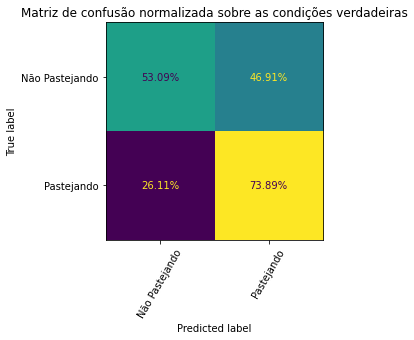


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.9939004864362
{'Não Pastejando': {'precision': 0.9998812243671704, 'recall': 0.9999790375437592, 'f1-score': 0.9999301285634433, 'support': 143113, 'specificity': 0.9999079996969402, 'npv': 0.9999837634222376}, 'Pastejando': {'precision': 0.9999837634222376, 'recall': 0.9999079996969402, 'f1-score': 0.9999458801244757, 'support': 184782, 'specificity': 0.9999790375437592, 'npv': 0.9998812243671704}, 'accuracy': 0.999939004864362, 'macro avg': {'precision': 0.9999324938947041, 'recall': 0.9999435186203497, 'f1-score': 0.9999380043439595, 'support': 327895}, 'weighted avg': {'precision': 0.9999390092424306, 'recall': 0.999939004864362, 'f1-score': 0.9999390052006311, 'support': 327895}}

 ________________________________________________________________________________________________________________________________

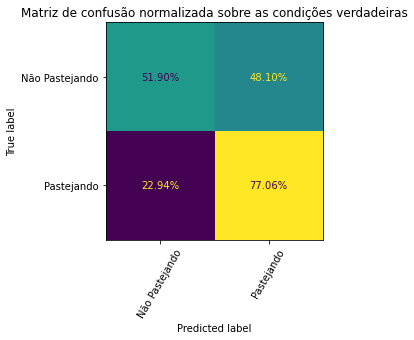


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  80.08417328718035
{'Não Pastejando': {'precision': 0.8115939707507729, 'recall': 0.7080698469041946, 'f1-score': 0.7563057196487679, 'support': 143113, 'specificity': 0.8726932276953383, 'npv': 0.7942296231721312}, 'Pastejando': {'precision': 0.7942296231721312, 'recall': 0.8726932276953383, 'f1-score': 0.831614748117034, 'support': 184782, 'specificity': 0.7080698469041946, 'npv': 0.8115939707507729}, 'accuracy': 0.8008417328718035, 'macro avg': {'precision': 0.8029117969614521, 'recall': 0.7903815372997665, 'f1-score': 0.7939602338829009, 'support': 327895}, 'weighted avg': {'precision': 0.8018084635784263, 'recall': 0.8008417328718035, 'f1-score': 0.7987453814259318, 'support': 327895}}

 ______________________________________________________________________________________________________________________________

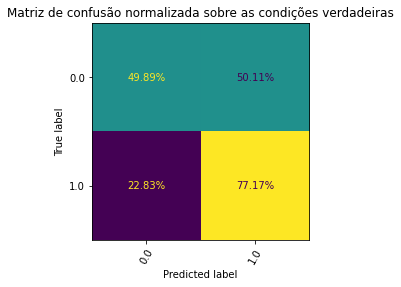


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  87.34533920919807
{'Não Pastejando': {'precision': 0.901101243339254, 'recall': 0.7976004975089614, 'f1-score': 0.8461977552745119, 'support': 143113, 'specificity': 0.9322011884274443, 'npv': 0.8560481065500447}, 'Pastejando': {'precision': 0.8560481065500447, 'recall': 0.9322011884274443, 'f1-score': 0.8925031476520846, 'support': 184782, 'specificity': 0.7976004975089614, 'npv': 0.901101243339254}, 'accuracy': 0.8734533920919807, 'macro avg': {'precision': 0.8785746749446494, 'recall': 0.8649008429682028, 'f1-score': 0.8693504514632983, 'support': 327895}, 'weighted avg': {'precision': 0.8757119915294256, 'recall': 0.8734533920919807, 'f1-score': 0.8722927033960527, 'support': 327895}}

 _______________________________________________________________________________________________________________________________

In [222]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [223]:
df_test = df[df['Altura esperada'] == 25.0]

In [224]:
df_train = df[df['Altura esperada'] != 25.0]

         Current function value: 0.653636
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  59.498666093713624
{'Não Pastejando': {'precision': 0.5979540403449632, 'recall': 0.4275308876639422, 'f1-score': 0.49858133390079984, 'support': 131525, 'specificity': 0.7440736478711162, 'npv': 0.5934800449205252}, 'Pastejando': {'precision': 0.5934800449205252, 'recall': 0.7440736478711162, 'f1-score': 0.6602992677491244, 'support': 147730, 'specificity': 0.4275308876639422, 'npv': 0.5979540403449632}, 'accuracy': 0.5949866609371363, 'macro avg': {'precision': 0.5957170426327443, 'recall': 0.5858022677675292, 'f1-score': 0.5794403008249621, 'support': 279255}, 'weighted avg': {'precision': 0.5955872309984798, 'recall': 0.5949866609371363, 'f1-score': 0.5841324981321045, 'support': 279255}}


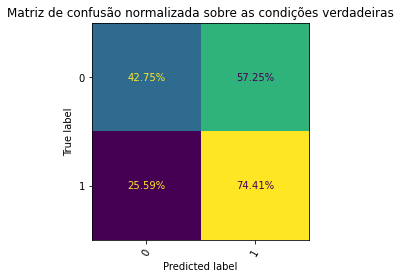

In [225]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Animals Out

In [112]:
df.Animal.value_counts()

95     119449
81     113724
84     110268
93      98043
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [113]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [114]:
df_test.Animal.value_counts()

84    110268
93     98043
Name: Animal, dtype: int64

In [115]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

In [116]:
df_train.Animal.value_counts()

95     119449
81     113724
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [117]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

##### Quantidade de dados por conjunto

In [118]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  398839
Teste:  208311
-------------------------------------------


##### Treino e teste

LGBMClassifier

 ----------------------------------------------------------------------  Teste  ---------------------------------------------------------------------- 

Acurácia teste:  59.96034774927872
{'Não Pastejando': {'precision': 0.5915864027509281, 'recall': 0.3674267377860892, 'f1-score': 0.4533090379964213, 'support': 94114, 'specificity': 0.790948974141177, 'npv': 0.6027305849537562}, 'Pastejando': {'precision': 0.6027305849537562, 'recall': 0.790948974141177, 'f1-score': 0.6841302001476965, 'support': 114197, 'specificity': 0.3674267377860892, 'npv': 0.5915864027509281}, 'accuracy': 0.5996034774927872, 'macro avg': {'precision': 0.5971584938523422, 'recall': 0.5791878559636331, 'f1-score': 0.5687196190720589, 'support': 208311}, 'weighted avg': {'precision': 0.5976956921068256, 'recall': 0.5996034774927872, 'f1-score': 0.579846207201068, 'support': 208311}}


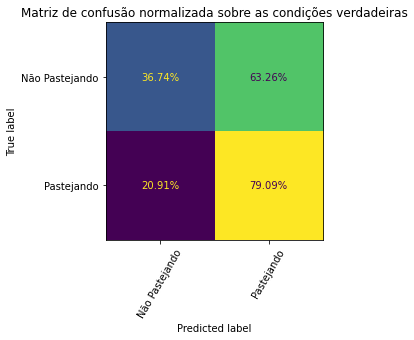


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  83.30103124318335
{'Não Pastejando': {'precision': 0.8447418113152735, 'recall': 0.7731658948394673, 'f1-score': 0.8073706008931257, 'support': 180524, 'specificity': 0.8824954767194192, 'npv': 0.8247128773901914}, 'Pastejando': {'precision': 0.8247128773901914, 'recall': 0.8824954767194192, 'f1-score': 0.8526263149276652, 'support': 218315, 'specificity': 0.7731658948394673, 'npv': 0.8447418113152735}, 'accuracy': 0.8330103124318334, 'macro avg': {'precision': 0.8347273443527324, 'recall': 0.8278306857794433, 'f1-score': 0.8299984579103954, 'support': 398839}, 'weighted avg': {'precision': 0.8337784483797173, 'recall': 0.8330103124318334, 'f1-score': 0.8321425043665835, 'support': 398839}}

 _____________________________________________________________________________________________________________________________

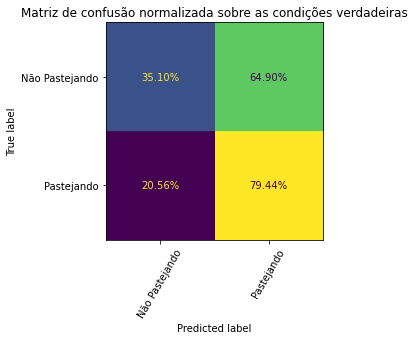


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  88.54600477887067
{'Não Pastejando': {'precision': 0.9016639559614663, 'recall': 0.83837606080078, 'f1-score': 0.8688690700017511, 'support': 180524, 'specificity': 0.9243936513753063, 'npv': 0.8736849852372005}, 'Pastejando': {'precision': 0.8736849852372005, 'recall': 0.9243936513753063, 'f1-score': 0.8983242859463922, 'support': 218315, 'specificity': 0.83837606080078, 'npv': 0.9016639559614663}, 'accuracy': 0.8854600477887067, 'macro avg': {'precision': 0.8876744705993334, 'recall': 0.8813848560880431, 'f1-score': 0.8835966779740716, 'support': 398839}, 'weighted avg': {'precision': 0.8863489316191425, 'recall': 0.8854600477887067, 'f1-score': 0.8849921559310467, 'support': 398839}}

 _________________________________________________________________________________________________________________________________

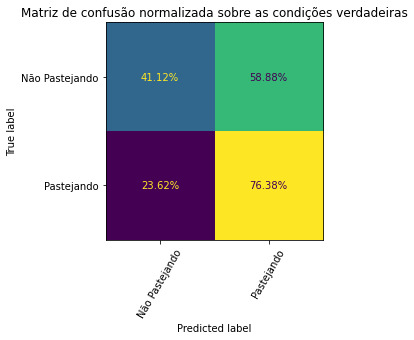


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  99.99423326204308
{'Não Pastejando': {'precision': 0.9998947595810324, 'recall': 0.9999778422813587, 'f1-score': 0.9999362992054018, 'support': 180524, 'specificity': 0.9999129697913566, 'npv': 0.9999816765918461}, 'Pastejando': {'precision': 0.9999816765918461, 'recall': 0.9999129697913566, 'f1-score': 0.999947322011383, 'support': 218315, 'specificity': 0.9999778422813587, 'npv': 0.9998947595810324}, 'accuracy': 0.9999423326204308, 'macro avg': {'precision': 0.9999382180864392, 'recall': 0.9999454060363576, 'f1-score': 0.9999418106083924, 'support': 398839}, 'weighted avg': {'precision': 0.9999423358893067, 'recall': 0.9999423326204308, 'f1-score': 0.9999423328277101, 'support': 398839}}

 ______________________________________________________________________________________________________________________________

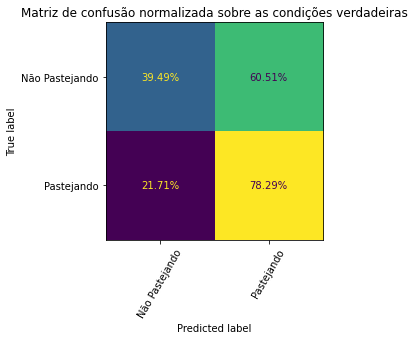


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  80.23011791725483
{'Não Pastejando': {'precision': 0.8034139062966279, 'recall': 0.7456737054352884, 'f1-score': 0.7734677108890639, 'support': 180524, 'specificity': 0.8491262625105925, 'npv': 0.8014950992048908}, 'Pastejando': {'precision': 0.8014950992048908, 'recall': 0.8491262625105925, 'f1-score': 0.824623446410619, 'support': 218315, 'specificity': 0.7456737054352884, 'npv': 0.8034139062966279}, 'accuracy': 0.8023011791725483, 'macro avg': {'precision': 0.8024545027507594, 'recall': 0.7973999839729404, 'f1-score': 0.7990455786498414, 'support': 398839}, 'weighted avg': {'precision': 0.8023635968478714, 'recall': 0.8023011791725483, 'f1-score': 0.8014691460556056, 'support': 398839}}

 ______________________________________________________________________________________________________________________________

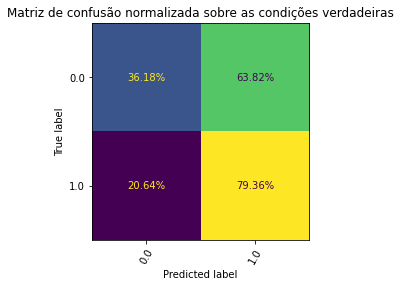


 ----------------------------------------------------------------------  Treino  ---------------------------------------------------------------------- 

Acurácia treino:  88.23359801824796
{'Não Pastejando': {'precision': 0.8981896001859877, 'recall': 0.8346480246393831, 'f1-score': 0.8652538065964734, 'support': 180524, 'specificity': 0.9217690035041111, 'npv': 0.870827311044373}, 'Pastejando': {'precision': 0.870827311044373, 'recall': 0.9217690035041111, 'f1-score': 0.8955743311652622, 'support': 218315, 'specificity': 0.8346480246393831, 'npv': 0.8981896001859877}, 'accuracy': 0.8823359801824796, 'macro avg': {'precision': 0.8845084556151803, 'recall': 0.878208514071747, 'f1-score': 0.8804140688808678, 'support': 398839}, 'weighted avg': {'precision': 0.8832121327017357, 'recall': 0.8823359801824796, 'f1-score': 0.8818505419238489, 'support': 398839}}

 ________________________________________________________________________________________________________________________________

In [232]:
treinar_e_reportar(models, X_train, y_train, X_test, y_test)

##### Com GLM 

In [233]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [234]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

         Current function value: 0.641980
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  60.28534258872551
{'Não Pastejando': {'precision': 0.6066596709515422, 'recall': 0.3439977049110653, 'f1-score': 0.439042582045023, 'support': 94114, 'specificity': 0.8161860644325157, 'npv': 0.6015424828164833}, 'Pastejando': {'precision': 0.6015424828164833, 'recall': 0.8161860644325157, 'f1-score': 0.6926157938931865, 'support': 114197, 'specificity': 0.3439977049110653, 'npv': 0.6066596709515422}, 'accuracy': 0.6028534258872551, 'macro avg': {'precision': 0.6041010768840127, 'recall': 0.5800918846717905, 'f1-score': 0.5658291879691048, 'support': 208311}, 'weighted avg': {'precision': 0.6038544060665418, 'recall': 0.6028534258872551, 'f1-score': 0.5780525242632675, 'support': 208311}}


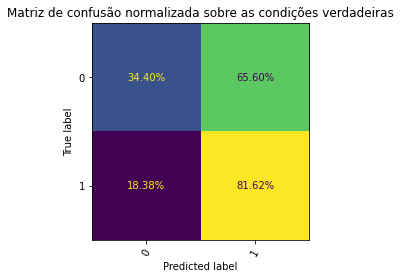

In [235]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')